In [35]:
from ls_mlkit.my_diffuser import Diffuser, ModelInterface4Diffuser, DiffusionConfig  # type: ignore
from ls_mlkit.my_utils import HF_MIRROR  # type: ignore
from typing import Any
import torch  # type: ignore
from torch import Tensor
from ls_mlkit.my_utils import ImageMasker,set_proxy  # type: ignore

set_proxy()

# !pip install diffusers
from diffusers import DDPMPipeline, DDIMPipeline, PNDMPipeline  # type: ignore

from diffusers.models.unets.unet_2d import UNet2DModel, UNet2DOutput  # type: ignore

# model_id = "google/ddpm-celebahq-256"
model_id = "google/ddpm-cat-256"


class Unet(ModelInterface4Diffuser):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model: torch.nn.Module = model

    def get_model_device(self):
        return next(self.model.parameters()).device

    def prepare_batch_data_for_input(self, batch: dict[str, Any]):
        return batch

    def __call__(self, x_t: Tensor, t: Tensor, padding_mask: Tensor) -> Tensor:
        result: UNet2DOutput = self.model.forward(x_t, t)  # type: ignore
        return result["sample"]


# load model and scheduler
pipeline = DDPMPipeline.from_pretrained(model_id, 
                                        # allow_pickle=True,
                                        ).to("cuda")  # type: ignore #

model = Unet(pipeline.unet)  # type: ignore

diffusion_config = DiffusionConfig(ndim_micro_shape=3)

diffuser = Diffuser(model=model, diffusion_config=diffusion_config, masker=ImageMasker())

image = pipeline()



model_index.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cat-256/snapshots/82ca0d5db4a5ec6ff0e9be8d86852490bc18a3d9: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cat-256/snapshots/82ca0d5db4a5ec6ff0e9be8d86852490bc18a3d9.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/1000 [00:00<?, ?it/s]

In [36]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

In [44]:
import torch
from tqdm.auto import tqdm
sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")
print(sample_size)


input = noise

for t in tqdm(scheduler.timesteps):
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample


256


  0%|          | 0/1000 [00:00<?, ?it/s]

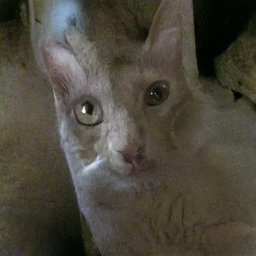

In [45]:
from PIL import Image
import numpy as np


def tensor_to_image(tensor_input):
    image = (input / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
    image = Image.fromarray(image)
    return image

tensor_to_image(input)

  0%|          | 0/1000 [00:00<?, ?it/s]

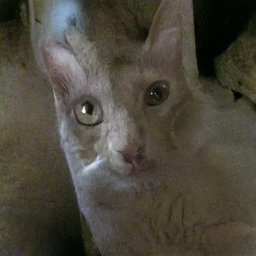

In [46]:
result = diffuser.sample_x0_unconditionally(shape=(1,3,256,256))

tensor_to_image(result)